In [1]:
#Model A - Baseline Model CNN

In [12]:

import os, random, numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [13]:
DATA_DIR = r"/Users/allendang/Downloads/natural_images_dataset/natural_images"
SPLIT_FILE = "splits.npz"

IMG_SIZE = 160        # was 224 (too slow on CPU)
BATCH_SIZE = 32
EPOCHS = 12           # start lower on CPU; you can increase later
LR = 1e-3

NUM_WORKERS = 0       # IMPORTANT for Windows/Jupyter
PIN_MEMORY = False    # only useful on CUDA

# Optional: debug speed mode (set to None for full epoch)
MAX_TRAIN_BATCHES = None  # e.g. 100 while debugging

In [14]:
#Transformations
eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [15]:
# Create dataset and splits
base_ds = datasets.ImageFolder(DATA_DIR, transform=eval_tfms)
n = len(base_ds)

train_size = int(0.70 * n)
val_size   = int(0.15 * n)
test_size  = n - train_size - val_size

g = torch.Generator().manual_seed(42)
train_split, val_split, test_split = torch.utils.data.random_split(
    range(n), [train_size, val_size, test_size], generator=g
)

train_idx = np.array(train_split.indices)
val_idx   = np.array(val_split.indices)
test_idx  = np.array(test_split.indices)

np.savez(SPLIT_FILE, train_idx=train_idx, val_idx=val_idx, test_idx=test_idx)

print("Saved:", SPLIT_FILE)
print("Sizes:", len(train_idx), len(val_idx), len(test_idx))
print("Classes:", base_ds.classes)

Saved: splits.npz
Sizes: 4829 1034 1036
Classes: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


In [16]:
#Subsets and DataLoaders
def subset_with_transform(data_dir, indices, transform):
    ds = datasets.ImageFolder(data_dir, transform=transform)
    ds.samples = [ds.samples[i] for i in indices]
    ds.targets = [ds.targets[i] for i in indices]
    return ds

train_tfms_A = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_ds = subset_with_transform(DATA_DIR, train_idx, train_tfms_A)
val_ds   = subset_with_transform(DATA_DIR, val_idx, eval_tfms)
test_ds  = subset_with_transform(DATA_DIR, test_idx, eval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

class_names = base_ds.classes
num_classes = len(class_names)
print("num_classes:", num_classes)

num_classes: 8


In [17]:
#Baseline CNN Model with Global Average Pooling for Efficiency
class BaselineCNN_GAP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        return self.classifier(x)

model = BaselineCNN_GAP(num_classes).to(device)


Epoch 01 | train 1.4664/0.4699 | val 1.1966/0.6044
Epoch 02 | train 0.9711/0.6670 | val 0.8670/0.7118
Epoch 03 | train 0.7911/0.7304 | val 0.7690/0.7524
Epoch 04 | train 0.6870/0.7645 | val 0.6313/0.7969
Epoch 05 | train 0.6236/0.7826 | val 0.6118/0.8008
Epoch 06 | train 0.5696/0.7981 | val 0.5478/0.8182
Epoch 07 | train 0.5086/0.8205 | val 0.4726/0.8366
Epoch 08 | train 0.4892/0.8287 | val 0.4546/0.8327
Epoch 09 | train 0.4311/0.8478 | val 0.4223/0.8588
Epoch 10 | train 0.4290/0.8432 | val 0.4488/0.8375
Epoch 11 | train 0.3898/0.8577 | val 0.3912/0.8656
Epoch 12 | train 0.3678/0.8621 | val 0.3809/0.8617


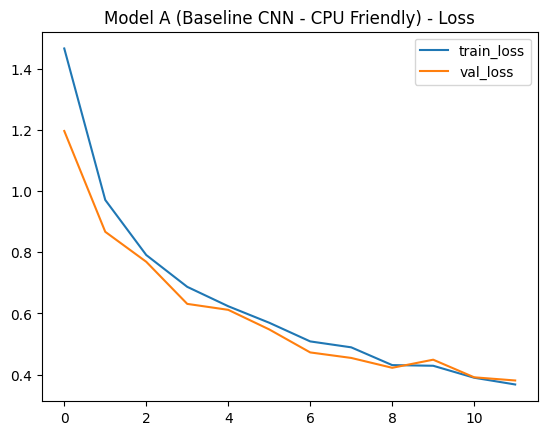

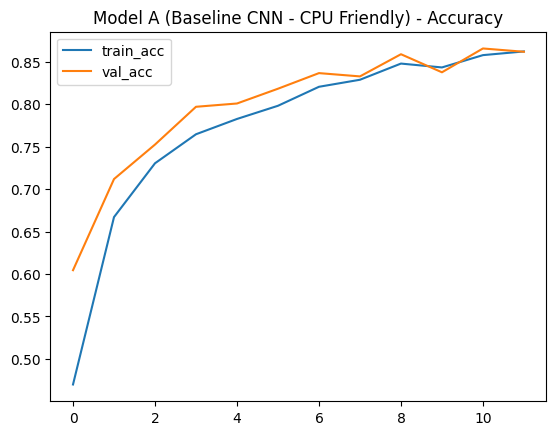

In [18]:
#Training and Evaluation Functions
def run_epoch(model, loader, optimizer=None, max_batches=None):
    is_train = optimizer is not None
    model.train(is_train)
    loss_fn = nn.CrossEntropyLoss()

    total_loss, total_correct, total_n = 0.0, 0, 0

    for i, (x, y) in enumerate(loader):
        if max_batches is not None and i >= max_batches:
            break

        x, y = x.to(device), y.to(device)

        if is_train:
            optimizer.zero_grad()

        logits = model(x)
        loss = loss_fn(logits, y)

        if is_train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total_n += x.size(0)

    return total_loss / total_n, total_correct / total_n

@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    ys, preds = [], []
    for x, y in loader:
        logits = model(x.to(device))
        p = logits.argmax(1).cpu().numpy()
        preds.extend(p)
        ys.extend(y.numpy())
    return np.array(ys), np.array(preds)

def plot_history(hist, title):
    plt.figure()
    plt.plot(hist["train_loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.legend()
    plt.title(title + " - Loss")
    plt.show()

    plt.figure()
    plt.plot(hist["train_acc"], label="train_acc")
    plt.plot(hist["val_acc"], label="val_acc")
    plt.legend()
    plt.title(title + " - Accuracy")
    plt.show()

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
best_val = -1
best_state = None

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model, train_loader, optimizer=optimizer, max_batches=MAX_TRAIN_BATCHES)
    va_loss, va_acc = run_epoch(model, val_loader, optimizer=None)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    if va_acc > best_val:
        best_val = va_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {ep:02d} | train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f}")

model.load_state_dict(best_state)
plot_history(history, "Model A (Baseline CNN - CPU Friendly)")

Model A Test Accuracy: 0.8407
Confusion Matrix:
 [[ 81   1   3  12   1   0   2   0]
 [  1 139   2   7   2   0   0   0]
 [  2   3  79  58   4   0   1   9]
 [  3   1  24  70   5   0   1   3]
 [  2   1   3   0 127   0   4   1]
 [  0   0   0   0   0 131   0   2]
 [  0   1   0   1   3   0 119   0]
 [  1   1   0   0   0   0   0 125]]

Classification Report:

              precision    recall  f1-score   support

    airplane       0.90      0.81      0.85       100
         car       0.95      0.92      0.93       151
         cat       0.71      0.51      0.59       156
         dog       0.47      0.65      0.55       107
      flower       0.89      0.92      0.91       138
       fruit       1.00      0.98      0.99       133
   motorbike       0.94      0.96      0.95       124
      person       0.89      0.98      0.94       127

    accuracy                           0.84      1036
   macro avg       0.84      0.84      0.84      1036
weighted avg       0.85      0.84      0.84      

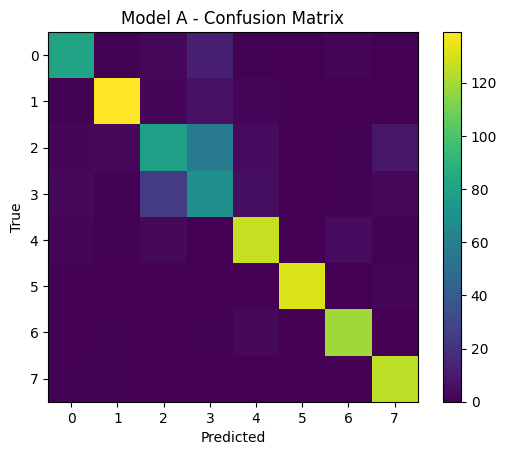

In [19]:
#Test Evaluation and Metrics
y_true, y_pred = predict_all(model, test_loader)
test_acc = (y_true == y_pred).mean()
print("Model A Test Accuracy:", round(float(test_acc), 4))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure()
plt.imshow(cm)
plt.title("Model A - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()